In [1]:
# pip install datasets

import os.path as op

import numpy as np
import pandas as pd

from local_dataset_utilities import download_dataset, load_dataset_into_to_dataframe, partition_dataset
from local_dataset_utilities import IMDBDataset

### binary classification

In [2]:
# download_dataset()

df = load_dataset_into_to_dataframe()
df.head()

100%|███████████████████████████████████| 50000/50000 [00:17<00:00, 2856.77it/s]

Class distribution:


,text,label
0,I went and saw this movie last night after bei...,1
0,Actor turned director Bill Paxton follows up h...,1
0,As a recreational golfer with some knowledge o...,1
0,"I saw this film in a sneak preview, and it is ...",1
0,Bill Paxton has taken the true story of the 19...,1


In [3]:
df.iloc[0]['text']

"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."

In [4]:
# partition_dataset(df)

In [5]:
df_train = pd.read_csv('train.csv')
df_train.tail()

,index,text,label
34995,0,Frank Capra's creativity must have been just a...,0
34996,0,Just saw the film tonight in a preview and it'...,0
34997,0,"If you love Japanese monster movies, you'll lo...",1
34998,0,Because it came from HBO and based on the IMDb...,0
34999,0,"WARNING!!! SOME POSSIBLE PLOT SPOILERS, AS IF ...",0


In [6]:
df_test = pd.read_csv('test.csv')
df_test.tail()

,index,text,label
9995,0,Every generation fully believes it is living i...,0
9996,0,Possibly the most brilliant thing about Che: P...,1
9997,0,I was unsure of this movie before renting and ...,1
9998,0,"Just got out of an advance screening, and wow ...",1
9999,0,I sense out there a mix of confusion and varyi...,1


In [7]:
df_val = pd.read_csv('val.csv')
df_val.tail()

,index,text,label
4995,0,The Matador is a strange film. Its main charac...,1
4996,0,Not bad performances. Whoopi plays the wise/wa...,0
4997,0,I was surprised when I saw this film. I'd hear...,0
4998,0,When great director/actor combinations are tal...,0
4999,0,This show is non Stop hilarity. the first joke...,1


In [8]:
np.bincount(df_train['label'])

array([17452, 17548])

In [9]:
np.bincount(df_test['label'])

array([5006, 4994])

In [10]:
np.bincount(df_val['label'])

array([2542, 2458])

## bag of words

In [11]:
# pip install scikit-learn

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
cv = CountVectorizer(lowercase=True, max_features=10_000, stop_words="english")

In [14]:
# it will build the vocabulary before we transform the feature vectors
cv.fit(df_train['text'])

CountVectorizer(max_features=10000, stop_words='english')

In [15]:
cv.vocabulary_

{'started': 8515,
 'watching': 9725,
 'series': 7957,
 'cable': 1320,
 'idea': 4488,
 'hate': 4191,
 'character': 1544,
 'hold': 4339,
 'beautifully': 892,
 'developed': 2574,
 'understand': 9375,
 'react': 7196,
 'frustration': 3737,
 'fear': 3439,
 'greed': 4020,
 'temptation': 8974,
 'way': 9736,
 'viewer': 9574,
 'experiencing': 3280,
 'christopher': 1656,
 'learning': 5199,
 'br': 1151,
 'abuse': 188,
 'physically': 6608,
 'emotionally': 3046,
 'just': 4963,
 'read': 7199,
 'newspaper': 6088,
 'women': 9880,
 'tolerate': 9134,
 'behavior': 915,
 'dream': 2831,
 'house': 4418,
 'endless': 3074,
 'supply': 8779,
 'expensive': 3276,
 'things': 9036,
 'sure': 8791,
 'loving': 5426,
 'faithful': 3371,
 'husband': 4465,
 'maybe': 5640,
 'watch': 9719,
 'doesn': 2754,
 'matter': 5630,
 'times': 9104,
 'episode': 3140,
 'missed': 5813,
 'episodes': 3141,
 'sequence': 7950,
 'season': 7869,
 'late': 5151,
 'night': 6101,
 'commercials': 1874,
 'language': 5133,
 'reruns': 7427,
 'movie': 5

In [16]:
#construct feature vectors
X_train = cv.transform(df_train['text'])
X_val = cv.transform(df_val['text'])
X_test = cv.transform(df_test['text'])

In [17]:
X_train.shape

(35000, 10000)

In [18]:
X_train[0]

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 74 stored elements in Compressed Sparse Row format>

In [19]:
# convert sparse rep to dense for vizualization
feat_vec = np.array(X_train[0].todense())[0]

In [20]:
feat_vec

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
feat_vec.shape

(10000,)

In [22]:
np.bincount(feat_vec)

array([9926,   67,    5,    0,    1,    0,    1])

# training logistic regression classifier

## defining data loader

In [27]:
# pip install torch lightning

In [31]:
# pip install datasets

import os.path as op

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import torch

from sklearn.feature_extraction.text import CountVectorizer

from local_dataset_utilities import download_dataset, load_dataset_into_to_dataframe, partition_dataset
from local_dataset_utilities import IMDBDataset

from local_utilities import LightningModel

In [32]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.labels.shape[0]

In [33]:
train_ds = TextDataset(X_train.todense(), df_train["label"].values)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True
)

In [42]:
test_ds = TextDataset(X_train.todense(), df_test["label"].values)

test_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True
)

In [43]:
val_ds = TextDataset(X_train.todense(), df_val["label"].values)

val_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True
)

In [34]:
for batch_idx, (features, class_labels) in enumerate(train_loader):
    break

In [35]:
features.shape

torch.Size([32, 10000])

## implement the classifier

In [37]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        return logits

pytorch_model = LogisticRegression(num_features=10_000, num_classes=2)
        

In [39]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [40]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

In [41]:
trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=30,
    accelerator="cpu",
    logger=CSVLogger(save_dir="logs/", name="my_model"),
    deterministic=True
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ashugulati/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [ ]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

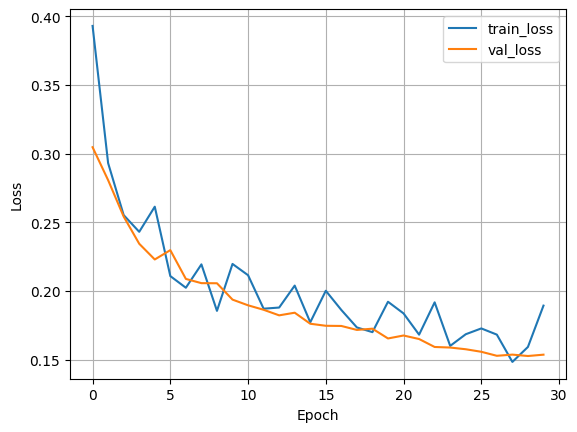

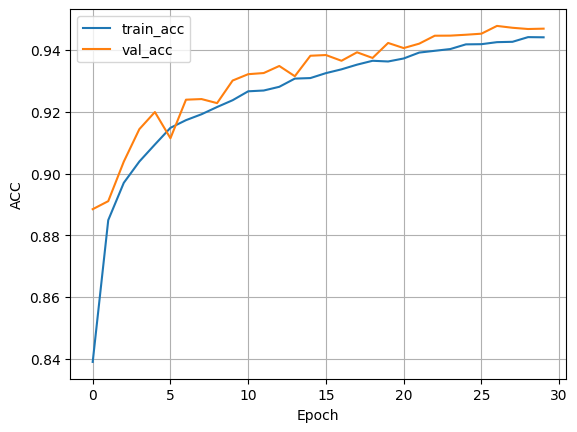

In [45]:
from local_utilities import plot_csv_logger

plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

In [53]:
trainer.test(model=lightning_model, dataloaders=test_loader)

Testing DataLoader 0: 100%|████████████████| 1094/1094 [00:10<00:00, 107.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9494571685791016     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9494571685791016}]

In [54]:
# load saved checkpoint

checkpoint_callback = ModelCheckpoint(dirpath='my/path/')
trainer = L.Trainer(callbacks=[checkpoint_callback])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## early stopping

In [55]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")
trainer = L.Trainer(callbacks=[early_stop_callback])

trainer = L.Trainer(
    callbacks=callbacks
)

In [ ]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)